# Python для Data Science 1.5 - курсовой проект
<br>

## Оглавление
---

1. [Цель курсового проекта](#1-Цель-курсового-проекта)
2. [Метрика соревнования](#2-Метрика-соревнования)
3. [Описание датасета](#3-Описание-датасета)
4. [Полезные функции](#4-Полезные-функции)
5. [Подключение библиотек](#5-Подключение-библиотек)
6. [Загрузка датасета](#6-Загрузка-датасета)
7. [Исследование и обработка данных](#7-Исследование-и-обработка-данных)
8. [Разбиение данных](#8-Разбиение-данных)
9. [Построение модели](#9-Построение-модели)
10. [Предсказание на тестовых данных](#10-Предсказание-на-тестовых-данных)
<br><br>

## 1. Цель курсового проекта
---
Цель курсового проекта - получить score больше 0.6 на в соревновании <a href="https://www.kaggle.com/c/realestatepriceprediction/overview">Real Estate Price Prediction</a>.<br>
Задача соревнования - предсказать цены на квартиры в датасете test.csv

<br>

## 2. Метрика соревнования
---

Метрика для оценки – коэффициент детерминации: <br>
$$R^2 = 1 - \frac{\sigma^2}{\sigma_y^2}$$

## 3. Описание датасета
---
### Файлы
`train.csv` - the training set <br>
`test.csv` - the test set <br>
`sampleSubmission.csv` - a sample submission file in the correct format <br>

### Столбцы
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

## 4. Полезные функции
---

In [77]:
def sns_scatterplot(df, target_column, feature_column, hue=None, palette='deep', limit=float('inf')):

#     feature_column.drop([target_column], errors='ignore')
    
    nrow, ncol = feature_column.shape[0]//2 + 1, 2
    plt.figure(figsize=(16, 8 * nrow))
    
    for i, feature in enumerate(feature_column.drop([target_column], errors='ignore')):
        plt.subplot(nrow, ncol, i + 1)
        sns.scatterplot(df.loc[df[target_column] < limit, feature],\
                        df.loc[df[target_column] < limit, target_column],\
                        hue=hue,\
                        data=df, palette=palette)

## 5. Подключение библиотек
---

In [78]:
import numpy as np
import pandas as pd
import random as rnd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [79]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SAMPLE_SUBMISSION_PATH = 'sample_submission.csv'

## 6. Загрузка датасета
---

In [80]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [81]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


## 7. Исследование и обработка данных
---

In [82]:
# Ecology_2, Ecology_3, Shops_2
replace_AB = {'A': 0, 'B': 1}
df['Ecology_2'].replace(replace_AB, inplace=True)
df['Ecology_3'].replace(replace_AB, inplace=True)
df['Shops_2'].replace(replace_AB, inplace=True)
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Матриц корреляций

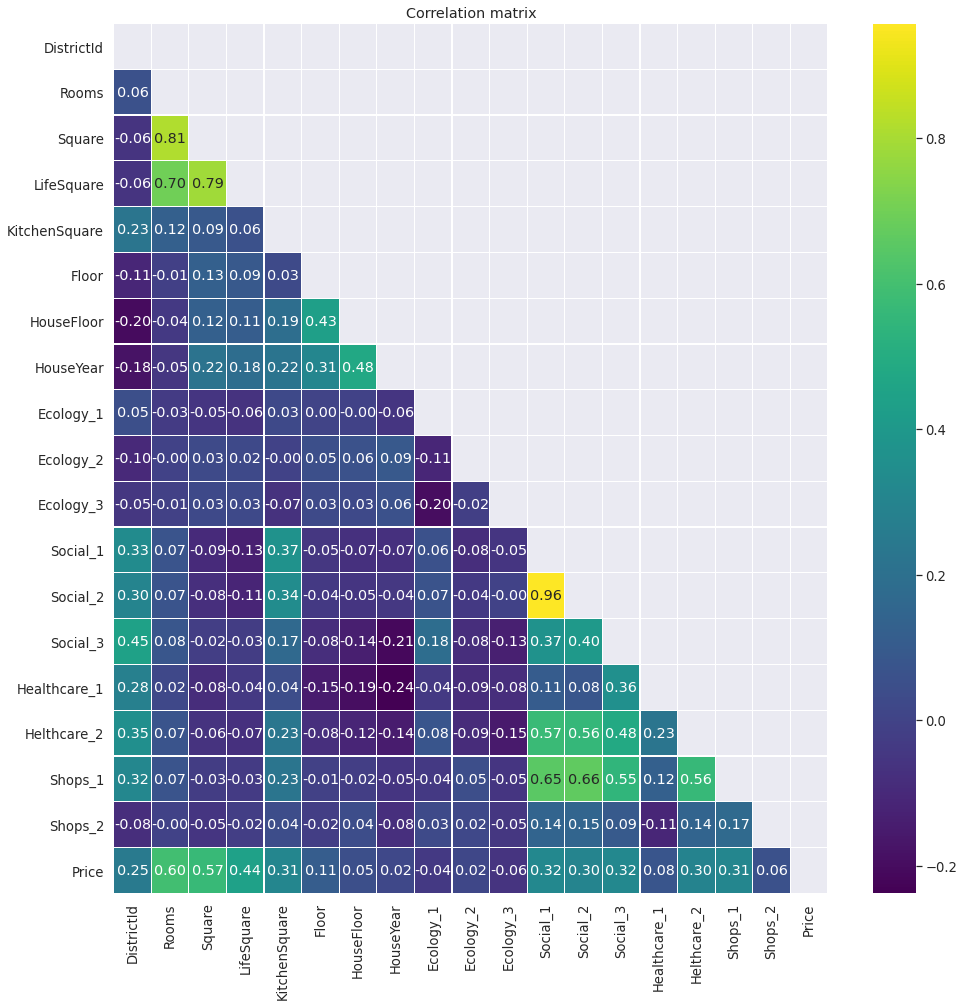

In [83]:
features = pd.DataFrame(df.select_dtypes(include=('int64', 'float64'))).drop('Id', axis=1)
correlation_matrix = features.corr(method='spearman')

mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices(correlation_matrix.shape[0])] = True

plt.figure(figsize = (16, 16))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', linewidths=0.2, cmap='viridis')
plt.title('Correlation matrix')
plt.show()

Диаграммы рассеяния признаков относительно `Price`

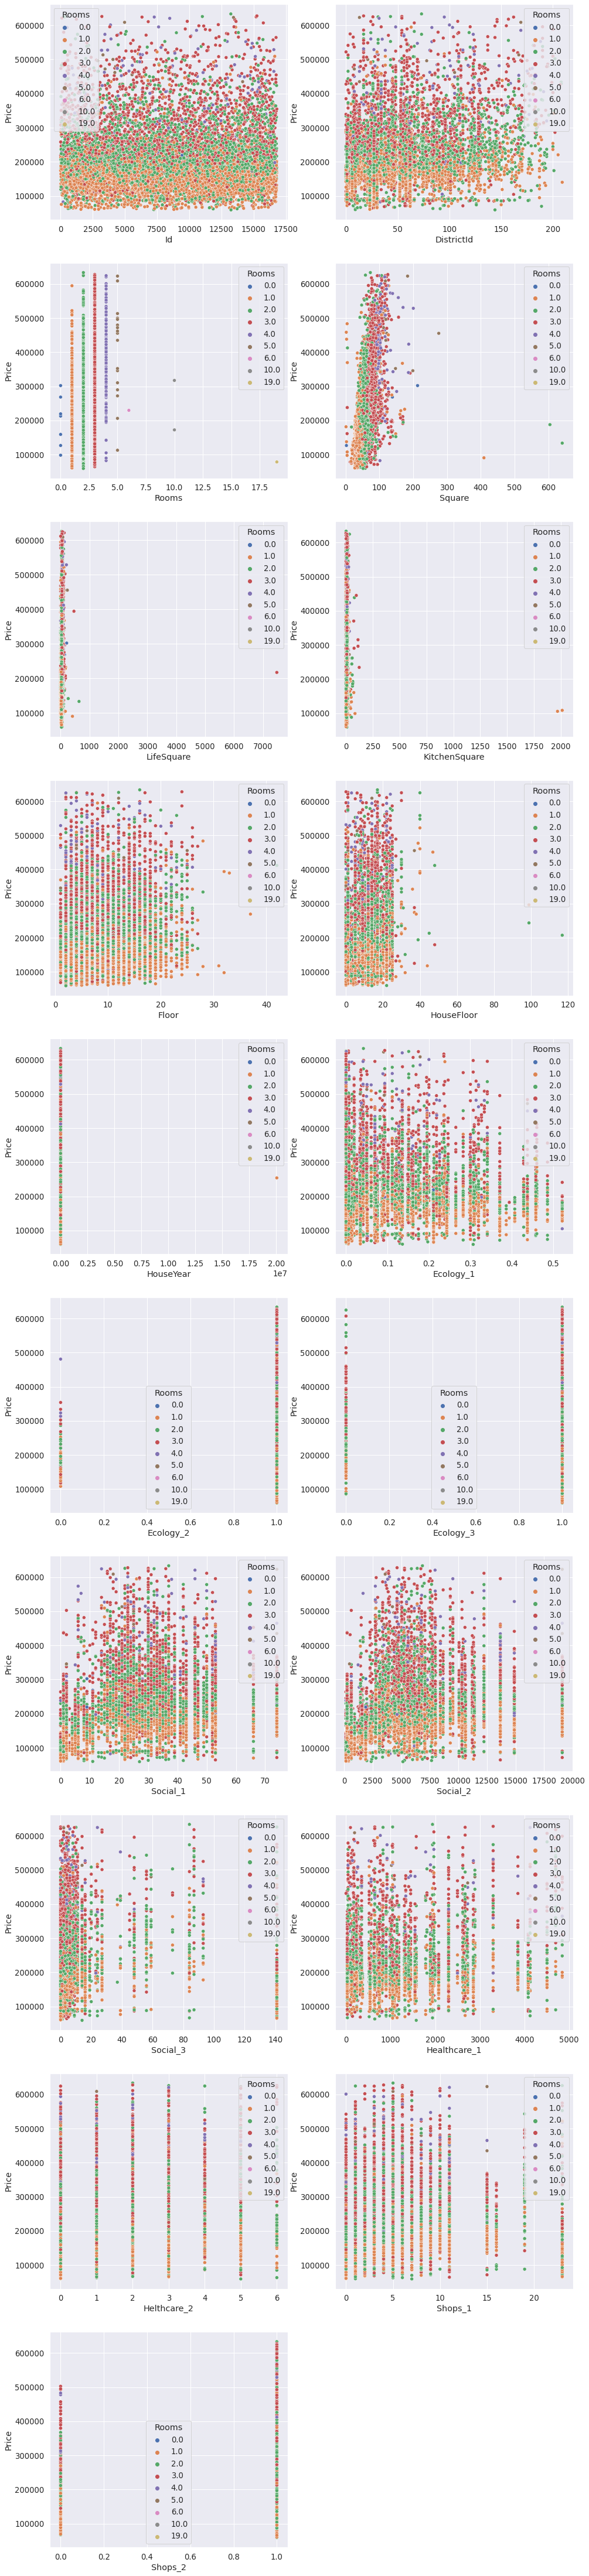

In [84]:
sns_scatterplot(df, 'Price', df.columns, hue='Rooms')

### Rooms
<br>

In [85]:
df['Rooms'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10., 19.])

In [86]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [87]:
df[(df['Rooms'] == 0) | (df['Rooms'] > 5)][['Rooms', 'Square', 'KitchenSquare']]

,Rooms,Square,KitchenSquare
377,10.0,59.056975,10.0
1397,0.0,138.427694,0.0
1454,19.0,42.006046,7.0
1981,0.0,212.932361,0.0
2170,6.0,59.414334,6.0
2269,0.0,41.790881,0.0
3911,0.0,49.483501,0.0
4366,0.0,81.491446,0.0
4853,0.0,2.377248,0.0
6149,0.0,38.697117,9.0


*Вариант обработки*

In [88]:
rm_median = df['Rooms'].median()
df.loc[df['Rooms'] == 0, 'Rooms'] = rm_median
df.loc[df['Rooms'] > 5, 'Rooms'] = 5

df[(df['Rooms'] == 0) | (df['Rooms'] > 5)]['Rooms']

Series([], Name: Rooms, dtype: float64)

### Square, LifeSquare, KitchenSquare
<br>

<AxesSubplot:xlabel='Square', ylabel='Density'>

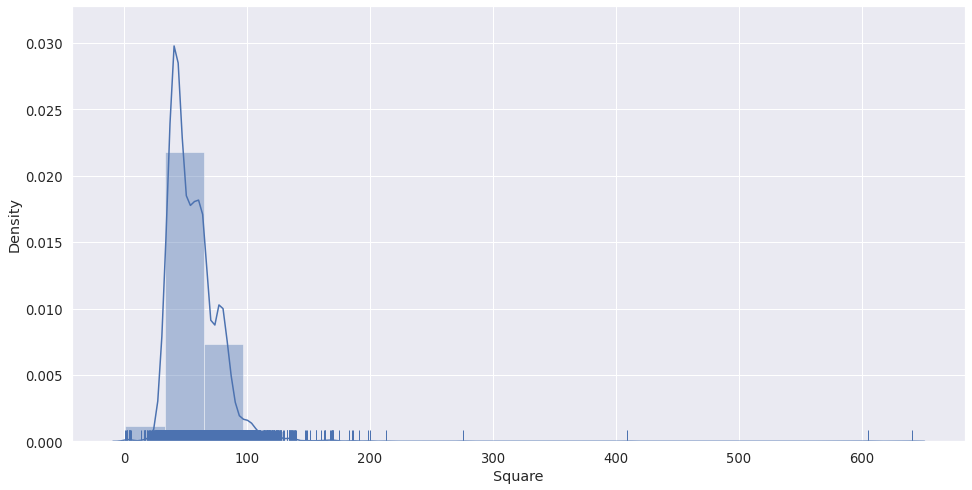

In [89]:
plt.figure(figsize=(16, 8))
sns.distplot(df['Square'], bins=20, rug=True, norm_hist=True)

In [90]:
sq_quan_l = df['Square'].quantile(0.0125)
sq_quan_r = df['Square'].quantile(0.9875)
sq_quan_l, sq_quan_r

(30.455995547995403, 113.72746935097328)

In [91]:
df[df['Square'] <= sq_quan_l]['Square'].count(),\
df[df['Square'] >= sq_quan_r]['Square'].count()

(125, 125)

In [92]:
df[df['Square'] <= sq_quan_l][['Square', 'KitchenSquare']]

,Square,KitchenSquare
178,29.298168,5.0
211,30.447688,5.0
212,5.497061,1.0
219,28.535084,6.0
257,29.401008,1.0
...,...,...
9613,4.502784,1.0
9642,22.072457,2.0
9811,29.386944,5.0
9835,26.096679,5.0


In [93]:
df[(df['Square'] >= sq_quan_r) & (df['LifeSquare'].notna())][['Square', 'LifeSquare']]

,Square,LifeSquare
343,125.287183,127.477137
358,121.844004,122.497641
386,115.254741,56.404018
426,132.474700,68.131495
652,190.857689,107.376164
...,...,...
9813,122.438148,5.751401
9828,127.141143,4.811405
9852,117.201937,69.898092
9895,123.430072,125.806981


In [94]:
df[df['Square'] < df['KitchenSquare']][['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
1064,47.100719,46.447960,2014.0
5149,38.071692,19.723548,73.0
7088,38.220258,18.716856,84.0
8584,32.276663,19.278394,1970.0


In [95]:
ksq_quan_l = df['KitchenSquare'].quantile(0.025)
ksq_quan_r = df['KitchenSquare'].quantile(0.975)
ksq_quan_l, ksq_quan_r

(0.0, 13.0)

In [96]:
df[df['KitchenSquare'] <= ksq_quan_l]['KitchenSquare'].count(),\
df[df['KitchenSquare'] >= ksq_quan_r]['KitchenSquare'].count()

(697, 256)

In [97]:
df[df['KitchenSquare'] <= ksq_quan_l][['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
2,44.947953,29.197612,0.0
7,80.312926,NaN,0.0
23,118.907612,NaN,0.0
26,106.958871,0.641822,0.0
39,60.503248,NaN,0.0
...,...,...,...
9948,66.736039,NaN,0.0
9953,61.049491,NaN,0.0
9960,57.376642,NaN,0.0
9965,59.460685,NaN,0.0


In [98]:
df[df['LifeSquare'] > df['Square']][['Square', 'LifeSquare', 'KitchenSquare']]

,Square,LifeSquare,KitchenSquare
28,42.530043,43.967759,1.0
44,104.211396,106.340403,0.0
52,61.400054,65.224603,0.0
123,85.952306,89.803753,1.0
153,51.831473,53.491301,1.0
...,...,...,...
9884,59.015896,59.439082,12.0
9889,51.440463,53.134243,51.0
9895,123.430072,125.806981,123.0
9902,44.098768,44.267551,1.0


*Вариант обработки*

In [99]:
sq_median = df['Square'].median()
df.loc[(df['Square'] <= sq_quan_l) | (df['Square'] >= sq_quan_r), 'Square'] = sq_median

df[(df['Square'] <= sq_quan_l) | (df['Square'] >= sq_quan_r)]['Square'].count()

0

#### KitchenSquare - площадь кухни

In [100]:
ksq_quan_l = df['KitchenSquare'].quantile(0.015)
ksq_quan_r = df['KitchenSquare'].quantile(0.985)
ksq_cnd = (df['KitchenSquare'] > ksq_quan_l)\
        & (df['KitchenSquare'] < ksq_quan_r)\
        & (df['Square'] > sq_quan_l)\
        & (df['Square'] < sq_quan_r)
ksq_median = df[ksq_cnd]['KitchenSquare'].median()
ksq_fill = pd.Series([ksq_median\
                      if ksq_median/sq <= ksq_median\
                      else 1 for sq in df['Square']])

df.loc[df['KitchenSquare'] <= ksq_quan_l, 'KitchenSquare'] = ksq_median
df.loc[df['KitchenSquare'] >= ksq_quan_r, 'KitchenSquare'] = ksq_fill
df['KitchenSquare'].fillna(ksq_median, inplace=True)
df[(df['KitchenSquare'] <= ksq_quan_l) | (df['KitchenSquare'] >= ksq_quan_r)]['KitchenSquare'].count()

0

#### LifeSquare - жилая площадь

In [101]:
lsq_cnd = (df['LifeSquare'] > df['Square'])\
        | (df['LifeSquare'] > df['Square'] + df['KitchenSquare'])\
        | (df['LifeSquare'].isna())
df.loc[lsq_cnd, 'LifeSquare'] = df.loc[lsq_cnd, 'Square'] - df.loc[lsq_cnd, 'KitchenSquare']

### Floor, HouseFloor - этажи

In [102]:
df[df['Floor'] > df['HouseFloor']][['Floor', 'HouseFloor']]

,Floor,HouseFloor
7,14,0.0
14,5,4.0
16,6,5.0
21,15,1.0
23,2,0.0
...,...,...
9984,11,9.0
9985,10,1.0
9989,26,24.0
9991,18,17.0


In [103]:
df[df['Floor'] == df['HouseFloor'] + 1][['Floor', 'HouseFloor']].count()

Floor         700
HouseFloor    700
dtype: int64

<i>Вариант обработки</i>

In [104]:
# df['HouseFloor'].astype(np.int8)

# Обработка "последних" этажей
condition = (df['Floor'] == df['HouseFloor'] + 1)
df.loc[condition, 'HouseFloor'] += 1

# Обработка нулевых этажей
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

# Обработка несоответствия этажей
condition = (df['Floor'] > df['HouseFloor'])
df.loc[condition, 'Floor'] = df.loc[condition, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))

df.loc[df['Floor'] > df['HouseFloor'], ['Floor', 'HouseFloor']].count()

Floor         0
HouseFloor    0
dtype: int64

### HouseYear - год постройки дома

In [105]:
df[df['HouseYear'] > 2021]['HouseYear']

1497    20052011
4189        4968
Name: HouseYear, dtype: int64

In [106]:
df['HouseYear'].min()

1910

<i>Вариант обработки</i>

In [107]:
df.loc[df['HouseYear'] > 2021]['HouseYear'] = 2021
df[df['HouseYear'] > 2021]['HouseYear']

1497    20052011
4189        4968
Name: HouseYear, dtype: int64

### Healthcare_1

При наличии времени - попробую достроить недостающие данные с помощью модели, пока - drop

In [110]:
df.drop('Healthcare_1', axis=1, inplace=True)

<br>

## Класс для обработки данных
<br>

In [111]:
class DataProcessing:
    def __init__(self):
        self.sq_quan_l = None
        self.sq_quan_r = None
        self.ksq_quan_l = None
        self.ksq_quan_r = None
        self.ksq_median = None
        self.sq_median = None
        self.rm_median = None
    
    
    def fit(self, X):
        # Медианы
        self.sq_median = X['Square'].median()
        self.hfl_median = X['HouseFloor'].median()
        self.rm_median = X['Rooms'].median()
        
        # Квантили Square
        self.sq_quan_l = X['Square'].quantile(0.0125)
        self.sq_quan_r = X['Square'].quantile(0.9875)
        
        # Квантили KitchenSquare
        self.ksq_quan_l = X['KitchenSquare'].quantile(0.015)
        self.ksq_quan_r = X['KitchenSquare'].quantile(0.985)
        ksq_cnd = (X['KitchenSquare'] > self.ksq_quan_l)\
                        & (X['KitchenSquare'] < self.ksq_quan_r)\
                        & (X['Square'] > self.sq_quan_l)\
                        & (X['Square'] < self.sq_quan_r)
        self.ksq_median = X[ksq_cnd]['KitchenSquare'].median()

        
    def reduce_mem_usage(self, X):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        start_mem = X.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in X.columns:
            col_type = X[col].dtype

            if col_type != object:
                c_min = X[col].min()
                c_max = X[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        X[col] = X[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        X[col] = X[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        X[col] = X[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        X[col] = X[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        X[col] = X[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        X[col] = X[col].astype(np.float32)
                    else:
                        X[col] = X[col].astype(np.float64)
            else:
                X[col] = X[col].astype('category')

        end_mem = X.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return X
        
    
    def transform(self, X):
        X = self.reduce_mem_usage(X)
        
        # Id
        X.drop('Id', axis=1, inplace=True)
        
        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = self.rm_median
        X.loc[X['Rooms'] > 5, 'Rooms'] = 5
        
        
        # Square - площадь. 
        X.loc[(X['Square'] <= self.sq_quan_l) | (X['Square'] >= self.sq_quan_r), 'Square'] = self.sq_median

        
        # KitchenSquare
        ksq_fill = pd.Series([self.ksq_median\
                              if self.ksq_median/sq <= self.ksq_median\
                              else 1 for sq in X['Square']])
        X.loc[X['KitchenSquare'] <= self.ksq_quan_l, 'KitchenSquare'] = self.ksq_median
        X.loc[X['KitchenSquare'] >= self.ksq_quan_r, 'KitchenSquare'] = ksq_fill
        X['KitchenSquare'].fillna(self.ksq_median, inplace=True)

        # LifeSquare
        lsq_cnd = (X['LifeSquare'] > X['Square'])\
                | (X['LifeSquare'] > X['Square'] + X['KitchenSquare'])\
                | (X['LifeSquare'].isna())
        X.loc[lsq_cnd, 'LifeSquare'] = X.loc[lsq_cnd, 'Square']\
                                        - X.loc[lsq_cnd, 'KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor'] = X['HouseFloor'].astype(np.int8)
        fl_cnd = (X['Floor'] == X['HouseFloor'] + 1) 
        X.loc[fl_cnd, 'HouseFloor'] += 1 # Обработка "последних" этажей
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.hfl_median # Обработка нулевых этажей
        fl_cnd = (X['Floor'] > X['HouseFloor'])
        X.loc[fl_cnd, 'Floor'] = X.loc[fl_cnd, 'HouseFloor']\
                                    .apply(lambda x: rnd.randint(1, x)) # Обработка несоответствия этажей
        
        
        # HouseYear
        X.loc[X['HouseYear'] > 2021, 'HouseYear'] = 2021

        
        # Ecology_2, Ecology_3, Shops_2
        replace_AB = {'A': 0, 'B': 1}
        X['Ecology_2'].replace(replace_AB, inplace=True)
        X['Ecology_3'].replace(replace_AB, inplace=True)
        X['Shops_2'].replace(replace_AB, inplace=True)
        
        # Healthcare_1
        X.drop('Healthcare_1', axis=1, inplace=True)
        
        
        return X

## 8. Разбиение данных
---

In [112]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [113]:
dp = DataProcessing()
dp.fit(df)
df = dp.transform(df)
df.info()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.9%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float16
 2   Square         10000 non-null  float16
 3   LifeSquare     10000 non-null  float16
 4   KitchenSquare  10000 non-null  float16
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  int8   
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float16
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int16  
 13  Social_3       10000 non-null  int16  
 14  Helthcare_2    10000 non-null  int8   
 15  Shops_1        10000 non-null  int8   


In [114]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [115]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7000, 17), (7000,), (3000, 17), (3000,))

In [116]:
X_train.isna().sum() | X_valid.isna().sum() | y_train.isna().sum() | y_valid.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

## 9. Построение модели
---

### Пробная модель

In [117]:
rfreg = RandomForestRegressor(random_state=42)
rfreg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [118]:
y_train_predict = rfreg.predict(X_train)
y_valid_predict = rfreg.predict(X_valid)

In [119]:
r2(y_train, y_train_predict), r2(y_valid, y_valid_predict)

(0.9596578954167455, 0.7021497203148817)

In [121]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfreg.feature_importances_), columns=['features', 'importance'])
feature_importances.sort_values('importance')

,features,importance
9,Ecology_2,0.000617
16,Shops_2,0.000792
10,Ecology_3,0.001281
14,Helthcare_2,0.009660
15,Shops_1,0.019349
4,KitchenSquare,0.024883
5,Floor,0.025092
6,HouseFloor,0.028014
8,Ecology_1,0.043271
7,HouseYear,0.044424


### Перебор параметров

In [159]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 350, 400],
    'max_features': np.arange(2, 15),
    'max_depth': np.arange(5, 15),
}

grd_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                   param_grid=parameters,
                   scoring='r2',
                   cv=3,
                   return_train_score=True)

```Python
>>> grd_rfr.fit(X_train, y_train)
>>> GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [100, 150, 200, 250, 350, 400]},
             return_train_score=True, scoring='r2')
...
>>> grd_rfr.best_params_, grd_rfr.best_score_
>>> ({'max_depth': 14, 'max_features': 5, 'n_estimators': 350}, 0.7195319758252393)
...
>>> y_valid_predict_grd = grd_rfr.predict(X_valid)
>>> r2(y_valid, y_valid_predict_grd)
>>> 0.7147380701539052
```

<br>

### Случайный лес с лучшим набором параметров

In [122]:
grd_rfr_best = RandomForestRegressor(n_estimators=350, max_depth=14, max_features=5, random_state=42)
grd_rfr_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features=5, n_estimators=350,
                      random_state=42)

In [123]:
y_train_predict_best = grd_rfr_best.predict(X_train)
y_valid_predict_best = grd_rfr_best.predict(X_valid)
r2(y_train, y_train_predict_best), r2(y_valid, y_valid_predict_best)

(0.9249350301894974, 0.7139609179674435)

In [124]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfreg.feature_importances_), columns=['features', 'importance'])
feature_importances.sort_values('importance')

,features,importance
9,Ecology_2,0.000617
16,Shops_2,0.000792
10,Ecology_3,0.001281
14,Helthcare_2,0.009660
15,Shops_1,0.019349
4,KitchenSquare,0.024883
5,Floor,0.025092
6,HouseFloor,0.028014
8,Ecology_1,0.043271
7,HouseYear,0.044424


## 10. Предсказание на тестовых данных
---

### Загрузка и очистка

In [125]:
X_test = pd.read_csv(TEST_DATASET_PATH)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [126]:
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [127]:
# dp = DataProcessing()
# dp.fit(X_test)
submition = pd.DataFrame(X_test['Id'])
X_test = dp.transform(X_test)
X_test.info()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.15 MB
Decreased by 79.6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int16  
 1   Rooms          5000 non-null   float16
 2   Square         5000 non-null   float16
 3   LifeSquare     5000 non-null   float16
 4   KitchenSquare  5000 non-null   float16
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   int8   
 7   HouseYear      5000 non-null   int16  
 8   Ecology_1      5000 non-null   float16
 9   Ecology_2      5000 non-null   int64  
 10  Ecology_3      5000 non-null   int64  
 11  Social_1       5000 non-null   int8   
 12  Social_2       5000 non-null   int16  
 13  Social_3       5000 non-null   int16  
 14  Helthcare_2    5000 non-null   int8   
 15  Shops_1        5000 non-null   int8   
 

In [128]:
X_test.shape[1] == X_train.shape[1]

True

### Предсказание

In [129]:
y_test_prediction = grd_rfr_best.predict(X_test)

### Сохранение

In [132]:
submition['Price'] = y_test_prediction
submition.head()

,Id,Price
0,725,163483.485765
1,15856,227424.741563
2,5480,258401.564676
3,15664,337999.944998
4,14275,137227.485693


In [133]:
submition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [134]:
submition.to_csv('submition_v.1.csv', index=False)